In [1]:
import torch
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json

from config import seed_everything
seed_everything(0)



/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
model = resnet101(pretrained=True)
from models import *
backbone = BaseResnet(model, 20)
backbone2 = BaseResnet(model, 20)
te = TRANSFORMER_ENCODER_2_clf(backbone, 20, 2, 1)
te2 = TRANSFORMER_ENCODER_2_clf(backbone, 20, 2, 1)
# gcn = GCN_clf(backbone, 20)
##LT
p = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_fixed~0-4-4-1_resnet101_base_best.pth.tar'
p2= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_fixed~4-2-188-1_resnet101_base_best.pth.tar'

p3='/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_transformer_encoder-2-1-1_resnet101_transformer_encoder_best.pth.tar' 
##freeze
p4='/home/seongha/LT-ML/checkpoint/voc/voc_LT(True)_exp1_fixed~0-2-1-1_resnet101_transformer_encoder_best.pth.tar'

##uniform
path = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-16-1-2_resnet101_base_best.pth.tar'##finetune
path2='/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_base-16-1-1_resnet101_base_best.pth.tar'##freeze

path3= '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~4-2-1-1_resnet101_transformer_encoder_best.pth.tar'
path4 = '/home/seongha/LT-ML/checkpoint/voc/voc_LT(False)_exp1_fixed~0-2-1-1_resnet101_transformer_encoder_best.pth.tar'
di = torch.load(path)
print(di['best_score'])
di2 = torch.load(path2)
print(di2['best_score'])
backbone.load_state_dict(di['state_dict'])
backbone2.load_state_dict(di2['state_dict'])

{'mAP': tensor(92.9581), 'OF1': 0.8815602836879433, 'CF1': 0.867229564760918}
{'mAP': tensor(88.4351), 'OF1': 0.8063282597285746, 'CF1': 0.8006338479413285}


<All keys matched successfully>

In [40]:

train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl', LT=True)
test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')
# train_dataset = COCO2014('data/coco', phase='train', inp_name='data/coco/coco_glove_word2vec.pkl')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
test_dataset.transform = transforms.Compose([
                MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=32, shuffle=False,
                                            num_workers=4)

[dataset] read data/voc/files/VOC2007/classification_trainval_LT.csv
[dataset] VOC 2007 classification set=trainval number of classes=20  number of images=1058
[dataset] read data/voc/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=20  number of images=4952


In [41]:
## get feat representation from pretrained layers
def te_forward(model, feature):
    feature = model.features(feature)
    feature = feature.view(feature.size(0), -1)
    Z = model.blocks(feature)
    Z = Z.reshape((Z.shape[0], Z.shape[1])).detach().numpy()
    return Z
for i, (input, target) in tqdm(enumerate(test_loader)):
  img, path, inp = input
  target[target == 0] = 1
  target[target == -1] = 0
  feat_Var = torch.autograd.Variable(img).float().detach()
  if i==0:
    print(feat_Var.shape)
    # Z=g(feat_Var, None)
    Z = te_forward(te, feat_Var)
    Y = te_forward(te2, feat_Var)
    labels = target
  else:
    Z_ = te_forward(te, feat_Var)
    Z = np.concatenate((Z, Z_), axis=0)
    Y_ = te_forward(te, feat_Var)
    Y = np.concatenate((Y, Y_), axis=0)
    labels = np.concatenate((labels, target), axis=0)

    

0it [00:00, ?it/s]

torch.Size([32, 3, 224, 224])


18it [01:21,  4.56s/it]


KeyboardInterrupt: 

In [45]:
## get feat representation from pretrained layers

for i, (input, target) in tqdm(enumerate(test_loader)):
  img, path, inp = input
  target[target == 0] = 1
  target[target == -1] = 0
  feat_Var = torch.autograd.Variable(img).float().detach()
  if i==0:
    print(feat_Var.shape)
    # Z=g(feat_Var, None)
    Z1 = backbone(feat_Var, None).detach().numpy()
    Z2 = backbone2(feat_Var, None).detach().numpy()
    labels_ = target
  else:
    feature = backbone(feat_Var, None).detach().numpy()
    Z1 = np.concatenate((Z1, feature), axis=0)
    feature = backbone2(feat_Var, None).detach().numpy()
    Z2 = np.concatenate((Z2, feature), axis=0)
    labels_ = np.concatenate((labels_, target), axis=0)

0it [00:00, ?it/s]

torch.Size([32, 3, 224, 224])


130it [08:47,  4.06s/it]


KeyboardInterrupt: 

In [38]:
from CKA import CKA, CudaCKA
cka = CKA()
print(cka.linear_CKA(Z, Y))
print(cka.kernel_CKA(Z,Y))

0.9924117392942706
0.9929912313835226


# Visulizing t-SNE

In [77]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(Z)


/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [78]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [55]:
print(labels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


20


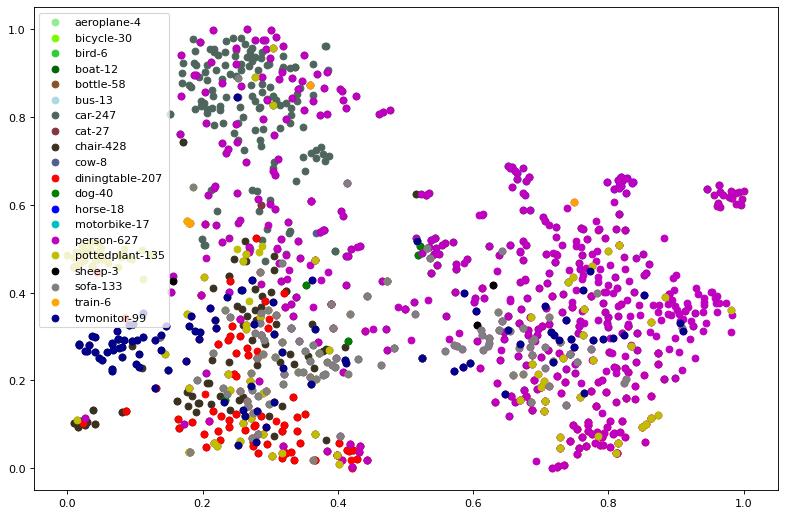

In [79]:
# initialize a matplotlib plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_subplot(111)
category_to_color = {0: 'lightgreen', 1: 'lawngreen', 2:'limegreen', 3: 'darkgreen'}
category_to_label = {0: 'A', 1:'B', 2:'C', 3:'D'}
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
nums=[4, 30, 6, 12, 58, 13, 247, 27, 428, 8, 207, 40, 18, 17, 627, 135, 3, 133, 6, 99]
colors = ['lightgreen', 'lawngreen', 'limegreen', 'darkgreen', '#875525','lightblue', '#4E655E', '#853541', '#3A3120', '#535D8E','r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey', 'orange', 'darkblue']
for i in range(20):
    category_to_color[i] = colors[i]
    category_to_label[i] = '{}-{}'.format(label_li[i],  str(nums[i]))
print(len(colors))
# for every class, we'll add a scatter plot separately
for category, color in category_to_color.items():
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l[category] == 1]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=category_to_label[category])

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

In [84]:
## check
import pandas as pd
coco_lt_path = "data/coco"
voc_lt_path = "data/voc/"
path_csv = './data/voc/files/VOC2007'
trainval_csv = os.path.join(path_csv, 'classification_trainval_LT.csv')
test_csv = os.path.join(path_csv, 'classification_test.csv')
hi = pd.read_csv(trainval_csv)
print(hi.columns)
print(hi.shape)
## generate gt pkl file
hi=hi.replace(0,1)
hi=hi.replace(-1,0)

hi=hi.iloc[:,1:]
di = dict()
adj = []
nums = []

for col_name, val in hi.iteritems():
  # print(col_name)
  if col_name =='name':
    continue
  if col_name == 'tvmonitor':
    M = hi[hi[col_name].isin([1.0])].sum(axis=0)
    print(M)

Index(['name', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')
(1058, 21)
aeroplane       0
bicycle         1
bird            0
boat            0
bottle          6
bus             0
car             1
cat             1
chair          73
cow             0
diningtable    13
dog             5
horse           0
motorbike       0
person         38
pottedplant    14
sheep           0
sofa           27
train           0
tvmonitor      99
dtype: int64
